
<p align="center">
  <img src="https://upload.wikimedia.org/wikipedia/fr/b/bb/UQO_Logo.png" alt="UQO" height="120">
  

  <h4 align="center"><b>INF6243 - Intelligence artificielle distribuée Enseignant : Alan Davoust</b></h4>
  <br>
  <h4 align="center"><b>Projet de session</b></h4>
  <h4 align="center"><b>Concepts de confiance dans les jeux à deux joueurs</b></h4>
  <h4 align="center"><b>Expérimentations du dilemme du prisonnier répété</b></h4>
  <h5 align="center"><b>Etudiant - Clément JOURET, Gaël Gelly</b></h5>
</p>

### Import des librairies

In [398]:
import random
import matplotlib.pyplot as plt
import numpy as np

### Définition des constantes

In [399]:
COOPERATE = 0 # Coopérer = ne pas dénoncer le joueur adverse
DEFECT = 1 # Dénoncer le joueur adverse
NUMBER_ROUNDS = 100

### Définition de la classe Prisoner

In [400]:
class Player:
    def __init__(self, strategy):
        self.strategy = strategy
        self.score = 0
        self.opponent_moves = []
        self.history_moves = []
        self.history_scores = []

    def make_move(self):
        move = self.strategy.make_move(self.opponent_moves, self.history_moves)
        self.history_moves.append(move)
        return move

### Définition de la classe Strategy

In [401]:
class Strategy:
    def make_move(self, opponent_moves, history_moves):
        """
        Méthode qui détermine le coup à jouer en fonction des coups précédents de l'adversaire.
        """
        pass

### Stratégie AlwaysCooperate : toujours coopérer

In [402]:
class AlwaysCooperate(Strategy):
    def make_move(self, opponent_moves, history_moves=None):
        return COOPERATE

### Stratégie AlwaysDefect : toujours trahir

In [403]:
class AlwaysDefect(Strategy):
    def make_move(self, opponent_moves, history_moves=None):
        return DEFECT

### Random : joue aléatoirement

In [404]:
class Random(Strategy):
    def make_move(self, opponent_moves, history_moves=None):
        return COOPERATE if random.random() < 0.5 else DEFECT

### TitForTat

In [405]:
class TitForTat(Strategy):
    def make_move(self, opponent_moves, history_moves=None):
        # Si c'est le premier coup, le joueur coopère
        # Sinon le joueur imite le coup précédent du joueur adverse
        if len(opponent_moves) == 0:
            return COOPERATE
        else: return opponent_moves[-1]

### TitForTwoTats

In [406]:
class TitForTwoTat(Strategy):
    def make_move(self, opponent_moves, history_moves=None):
        if len(opponent_moves) == 0:
            return COOPERATE
        
        # Si le joueur adverse a dénoncé durant les deux derniers tours, le dénoncer
        if opponent_moves[-2:] == [DEFECT, DEFECT]:
            return DEFECT
        else: return COOPERATE

### TwoTitForTat

In [407]:
class TwoTitForTat(Strategy):
    def make_move(self, opponent_moves, history_moves=None):
        if len(opponent_moves) == 0:
            return COOPERATE
        
        # Si le joueur adverse dénoncé au moins une fois dans les deux derniers tours, alors le dénoncer
        if DEFECT in opponent_moves[-2:]:
            return DEFECT
        else: return COOPERATE

### SpitefulTitForTat

In [408]:
class SpitefulTitForTat(Strategy):
    def make_move(self, opponent_moves, history_moves):
        if len(opponent_moves) < 2 :
            return COOPERATE
        
        # Si le joueur adverse a coopéré au tour précédent, le joueur coopère également
        if opponent_moves[-2] == opponent_moves[-1]:
            return opponent_moves[-1]
        else: return history_moves[-1]

### Adaptative

In [409]:
class Adaptative(Strategy):
    def __init__(self):
        self.opponent_strategy = None
        
    def make_move(self, opponent_moves, history_moves):
        # Joue la stratégie TitForTat pour les 6 premiers tours
        if len(opponent_moves) < 6:
            if len(opponent_moves) == 0:
                return COOPERATE
            else: return opponent_moves[-1]
        
        # Ensuite, tout les 6 tours, estimes la stratégie du joueur adverse
        if len(opponent_moves) % 6 == 0:
            
            if opponent_moves[-6:] == [COOPERATE, COOPERATE, COOPERATE, COOPERATE, COOPERATE, COOPERATE]:
                self.opponent_strategy = AlwaysCooperate()
                
            if opponent_moves[-6:].count(DEFECT) >= 4:
                self.opponent_strategy = AlwaysDefect()
                
            if opponent_moves[-6:].count(DEFECT) == 3:
                self.opponent_strategy = SpitefulTitForTat()
                
            if not self.opponent_strategy:
                self.opponent_strategy = Random()
        
        # Si l'adversaire adopte une stratégie Random ou AlwaysDefect
        if type(self.opponent_strategy) in [Random, AlwaysDefect]:
            return DEFECT
        
        if type(self.opponent_strategy) == SpitefulTitForTat:
            # Joue selon la stratégie TitForTwoTats
            if opponent_moves[-2:] == [DEFECT, DEFECT]:
                return DEFECT
            else:
                return COOPERATE
            
        if type(self.opponent_strategy) == AlwaysCooperate:
            #Joue selon la stratégie TitForTat
            if opponent_moves[-1] == DEFECT:
                return DEFECT
            else:
                return COOPERATE

### Définition de la méthode permettant de jouer des parties

In [410]:
def play_games(player1: Player, player2: Player):
    
    for i in range(NUMBER_ROUNDS):
        moveP1 = player1.make_move()
        moveP2 = player2.make_move()
        player1.opponent_moves.append(moveP2)
        player2.opponent_moves.append(moveP1)

        if moveP1 == DEFECT and moveP2 == DEFECT:
            player1.score += 3
            player2.score += 3
        elif moveP1 == COOPERATE and moveP2 == DEFECT:
            player1.score += 5
            player2.score += 0
        elif moveP1 == DEFECT and moveP2 == COOPERATE:
            player1.score += 0
            player2.score += 5
        elif moveP1 == COOPERATE and moveP2 == COOPERATE:
            player1.score += 1
            player2.score += 1

        player1.history_scores.append(player1.score)
        player2.history_scores.append(player2.score)    

### Affichage du résultats

In [411]:
def print_results(player1_scores, strategy1_name, player2_scores, strategy2_name):
    x = np.arange(NUMBER_ROUNDS)
    fig, ax = plt.subplots()
    ax.plot(x, player1_scores, '.-', color="tab:blue",   alpha=0.35, label=f"Joueur {strategy1_name}")
    ax.plot(x, player2_scores, '.-', color="tab:orange", alpha=0.35, label=f"Joueur {strategy2_name}")
    ax.set_xlabel('Numéro du tour')
    ax.set_ylabel('Score du joueur')
    fig.set_figwidth(10)
    fig.set_figheight(5)
#plt.title("Evolution du score des joueurs sur 100 parties")
    ax.legend()
    print(f"Score du joueur {strategy1_name} : {player1_scores[-1]} points")
    print(f"Score du joueur {strategy2_name} : {player2_scores[-1]} points")
    plt.show()

### Confrontation des stratégies

#### TitForTwoTats versus TitForTat

Si l'on confronte des stratégies dérivées de TitForTat celle-ci vont toujours opérer de manière à coopérer et donc les deux joueurs obtiennent le même score. On peut voir que les courbes sont superposées. Il n'est pas pas intéressant de confronter des stratégies diravant du TitForTat.


Score du joueur TitForTwoTats : 100 points
Score du joueur TitForTat : 100 points


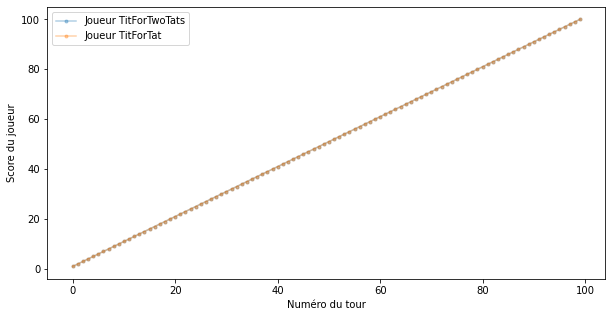

In [412]:
player1 = Prisoner(TitForTwoTats())
player2 = Prisoner(TitForTat())

play_games(player1, player2)
print_results(player1.history_scores, 'TitForTwoTats', player2.history_scores, 'TitForTat')

#### Adaptative versus all strategies

###### Adaptative versus AlwaysDefect

Score du joueur Adaptative : 302 points
Score du joueur Toujours dénoncer : 297 points


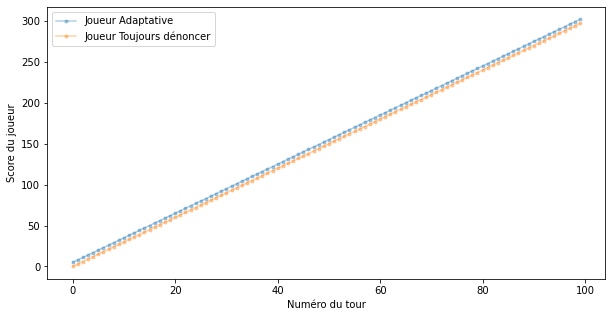

In [413]:
player1 = Prisoner(Adaptative())
player2 = Prisoner(AlwaysDefect())

play_games(player1, player2) 
print_results(player1.history_scores, 'Adaptative', player2.history_scores, 'Toujours dénoncer')

###### Adaptative versus AlwaysCooperate

Score du joueur Adaptative : 100 points
Score du joueur Toujours se taire : 100 points


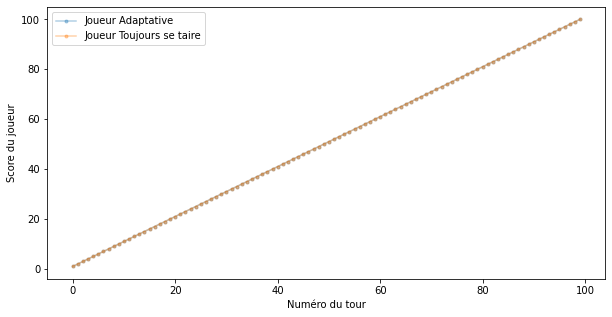

In [414]:
player1 = Prisoner(Adaptative())
player2 = Prisoner(AlwaysCooperate())

play_games(player1, player2) 
print_results(player1.history_scores, 'Adaptative', player2.history_scores, 'Toujours se taire')

###### Adaptative versus TitForTat

Score du joueur Adaptative : 100 points
Score du joueur TitForTat : 100 points


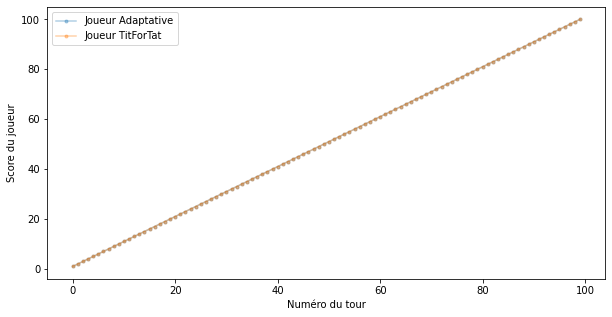

In [415]:
player1 = Prisoner(Adaptative())
player2 = Prisoner(TitForTat())

play_games(player1, player2) 
print_results(player1.history_scores, 'Adaptative', player2.history_scores, 'TitForTat')

###### Adaptative versus Random

Score du joueur Adaptative : 186 points
Score du joueur Random : 281 points


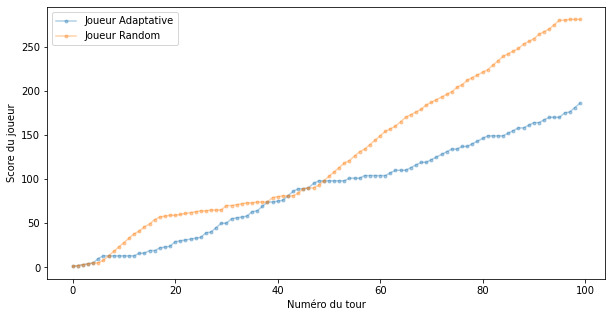

In [416]:
# Création de deux joueurs
player1 = Prisoner(Adaptative())
player2 = Prisoner(Random())

play_games(player1, player2) 
print_results(player1.history_scores, 'Adaptative', player2.history_scores, 'Random')